# Raw data cleanup and import

This notebook aims to clean the [raw recipe data](../data/raw/RAW_recipes.csv) obtained from [Food.com Recipes and Interactions dataset](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) in order to insert all recipe features into a MySQL DB.

In taking a look at the csv, I have discovered that it contains several flaws that should be corrected before inserting your data into the database. For example, there is a nutritional value column in which several categories are intertwined within a single one that makes it difficult to understand the information, there are also several null values and outliers that are far from representing the true cost of preparing some of the recipes.

This notebook will therefore serve to correct these shortcomings and ultimately perform part of the exploratory data analysis (EDA) of the dataset. This will be used to transform the data for our future recommender model.

## Data cleanup

### Understanding the dataset

Food.com dataset comes with a bunch of CSVs including the data already processed (wich will be ignored because the goal of this project is to learn how to properly process data in order to build a functional recommender system).

In this first part of the project, I will analyze [raw recipe data csv](../data/raw/RAW_recipes.csv) which contains many interesting features which will allow us to make an subsequent content based recommender such as the ingredients used in a recipe and its steps, as well as the elaboration time.

In order to evaluate the datasets we should firstly ensure we have installed the following libraries.

In [ ]:
%pip install pandas numpy matplotlib seaborn

Once there are installed, we can import them.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's read the csv.

In [3]:
recipe_df = pd.read_csv('../data/raw/RAW_recipes.csv')
recipe_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


Displaying general information about the structure of the dataset.

In [4]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


As we can see, we have a dataset wich has 231637 entries and a total fo 12 columns. It presents many cathegories that are of interest of our future recommender, some of them contains numerical data and many other cathegorical data.

### Exploratory Data Analysis (EDA)

The exploratory data analysis (EDA) is a crucial step in examinating data to understand its fundamental features, identify patterns, detect anomalies and test hypotheses.

Since our purpose here is not to prepare the data to train the recommender, but to have a clean representation of it and then add it to our database in order to get data about the recipes from the API Rest server, we will focus on reorganising some categories, modify or remove some outliers or null values.

#### Processing null values

I will check how many null values our rows contain to later decide whether to input data or erase these rows.

In [5]:
recipe_df.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [6]:
null_percentage = recipe_df.isnull().sum()/len(recipe_df)
null_percentage

name              0.000004
id                0.000000
minutes           0.000000
contributor_id    0.000000
submitted         0.000000
tags              0.000000
nutrition         0.000000
n_steps           0.000000
steps             0.000000
description       0.021495
ingredients       0.000000
n_ingredients     0.000000
dtype: float64

As we can see, this dataset only contains several null values among the *description* column and one in the *name* column.

In [7]:
# Ploting null value percentage per cathegory
def plot_null_values(null_percentage):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=null_percentage.index, y=null_percentage)
    plt.xticks(rotation=90)
    plt.ylabel('Percentage of null values (%)')
    plt.title('Percentage of null values per column')
    plt.show()

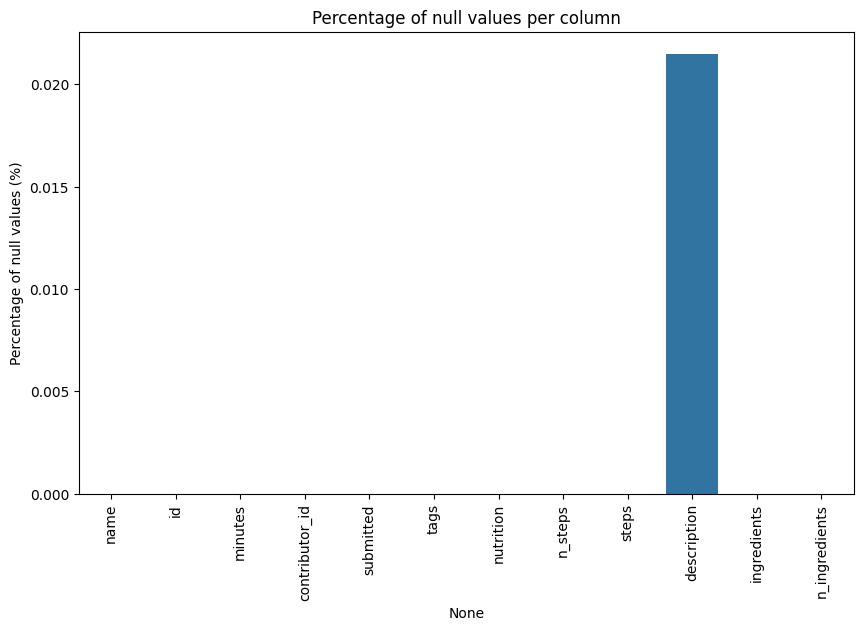

In [8]:
plot_null_values(null_percentage)

<Axes: >

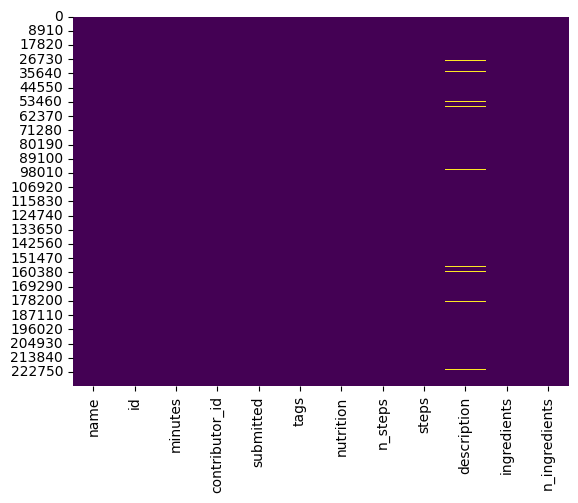

In [9]:
sns.heatmap(recipe_df.isnull(), cbar=False, cmap='viridis')

Regarding the *description* column, it contains almost 22% of null values. The description field is particularly valuable because it provides contextual information about the recipe, which can be crucial for multiple natural language processing (NLP) tasks. For example, this field could be transformed into an embedding vector to capture semantic similarities between recipes. Such embeddings can then be used in algorithms like K-Nearest Neighbors (KNN) to find recipes with similar descriptions, enhancing the accuracy of a content-based recommender system.

Keeping records with null description values could negatively impact the model's performance since these records would lack the necessary context for meaningful comparisons. Additionally, imputing these values could introduce noise, as generating synthetic or placeholder descriptions might not accurately reflect the underlying data. Therefore, to maintain data quality and ensure the integrity of the recommender system, I have decided to drop all records that do not contain a description.

In [10]:
recipe_df_cleaned = recipe_df.dropna(subset=['description'])

Apart from *description*, there is still one remaining null value at *name* column. Let's take a look at the row data.

In [11]:
last_null_row = recipe_df_cleaned[recipe_df_cleaned['name'].isnull()]
last_null_row

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
721,NaN,368257,10,779451,2009-04-27,"['15-minutes-or-less', 'time-to-make', 'course...","[1596.2, 249.0, 155.0, 0.0, 2.0, 112.0, 14.0]",6,"['in a bowl , combine ingredients except for o...",-------------,"['lemon', 'honey', 'horseradish mustard', 'gar...",10


The previous row did not contain an understable nor usefull description, so we can delete it.

In [12]:
recipe_df_cleaned = recipe_df_cleaned.drop(last_null_row.index)

#### Analyzing numeric columns

Selecting numeric columns.

In [13]:
non_cathegorical_cols = recipe_df_cleaned.select_dtypes(exclude=['object', 'category']).columns
non_cathegorical_cols

Index(['id', 'minutes', 'contributor_id', 'n_steps', 'n_ingredients'], dtype='object')

Let's now see how many different values we have in each numeric cathegory.

In [14]:
for col in non_cathegorical_cols:
    nunique = recipe_df_cleaned[col].nunique()
    print(col, nunique, round(nunique/len(recipe_df_cleaned), 4))

id 226657 1.0
minutes 877 0.0039
contributor_id 27693 0.1222
n_steps 94 0.0004
n_ingredients 41 0.0002


All the column *id* values are unique, so we can remove when training our model.

Let's now explore the numeric colums to see if we detect any kind of anomalies in their standard statistics.

In [15]:
recipe_df_cleaned.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,226657.000000,2.266570e+05,2.266570e+05,226657.000000,226657.000000
mean,226097.564368,9.602472e+03,5.655471e+06,9.773927,9.054170
std,139802.640862,4.510715e+06,1.008784e+08,5.999824,3.740942
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,105707.000000,2.000000e+01,5.810400e+04,6.000000,6.000000
50%,211971.000000,4.000000e+01,1.807890e+05,9.000000,9.000000
75%,336737.000000,6.500000e+01,4.091060e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


Extreme data (min and max values of each column) could be an indication that some inconclusive or unrealistic data needs to be discarded.

##### Outliers

We can see how in the minutes column there are values that have a preparation time of 0 minutes, let's see what we can do to correct it.

<Axes: xlabel='minutes'>

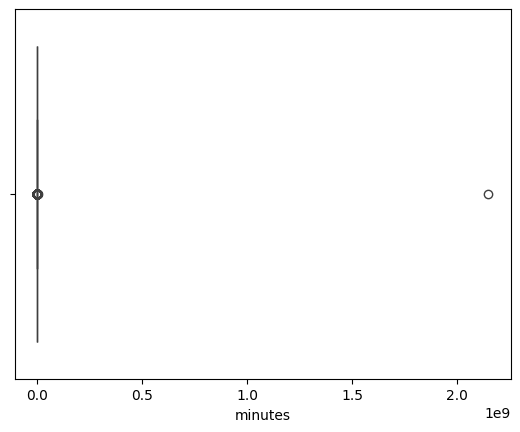

In [16]:
sns.boxplot(x=recipe_df_cleaned['minutes'])

In [17]:
zero_min_preparation_rows = recipe_df_cleaned[recipe_df_cleaned['minutes'] == 0]
zero_min_preparation_rows.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
3079,albanian byrek,4880,0,1534,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[354.4, 42.0, 25.0, 59.0, 37.0, 37.0, 2.0]",14,"['prepare the dough with flour , 1 and a half ...","the directions to this are vague, but maybe yo...","['flour', 'water', 'oil', 'vinegar', 'salt', '...",9
3440,all in one tuna casserole,7009,0,35526,2000-03-06,"['15-minutes-or-less', 'time-to-make', 'course...","[551.2, 33.0, 12.0, 46.0, 63.0, 51.0, 18.0]",5,"['preheat oven to 350 degrees f', 'in large bo...",i recently adopted this recipe. i made major ...,"['onion soup mix', 'milk', 'frozen peas and ca...",7
5153,an mochi 1,43301,0,32020,2002-10-16,"['15-minutes-or-less', 'time-to-make', 'course...","[1543.6, 6.0, 401.0, 0.0, 37.0, 6.0, 117.0]",11,"['boil water and sugar together', 'remove from...",from hawai'i's best mochi recipe book that my ...,"['mochiko sweet rice flour', 'sugar', 'water',...",5
5266,andouille in comforting barbecue sauce,6511,0,47510,2000-03-06,"['weeknight', '15-minutes-or-less', 'time-to-m...","[180.8, 21.0, 6.0, 25.0, 7.0, 16.0, 1.0]",12,"['saute onions , celery , bell pepper , and pa...",this is one of the zaar recipes that i adopted...,"['onions', 'celery', 'bell pepper', 'parsley',...",12
5725,another bean salad,7590,0,39547,2000-03-13,"['15-minutes-or-less', 'time-to-make', 'course...","[160.5, 0.0, 89.0, 5.0, 9.0, 0.0, 11.0]",4,"['combine sugar , salt vinegar in pan , bring ...","a sweet, tangy bean salad.","['sugar', 'salt', 'vinegar', 'green beans', 'y...",11


There are several rows containing the tag ‘in 15 minutes or less’, so we can check if these two characteristics are related: that the minutes are 0 and that they have this tag.

To get all the rows which have the "15-minutes-or-less" tag, we need to import pythoon's *ast* mudule.

In [18]:
import ast

In [19]:
recipe_df_cleaned['tags'] = recipe_df_cleaned['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [20]:
zero_min_rows = recipe_df_cleaned[recipe_df_cleaned['minutes'] == 0]
contains_tag = zero_min_rows['tags'].apply(lambda tags: '15-minutes-or-less' in tags)
contains_tag.sum() / len(zero_min_preparation_rows)

1.0

Although it is not known whether all recipes can be made in less than 15 minutes, it would be convenient to input a value of 15 to these rows for convenience.

In [21]:
recipe_df_cleaned.loc[recipe_df_cleaned['minutes'] == 0, 'minutes'] = 15

Now, let's replace as well the higher values to quantile 95.

In [22]:
max_preparation_rows = recipe_df_cleaned['minutes'].quantile(0.95)
recipe_df_cleaned['minutes'] = recipe_df_cleaned['minutes'].apply(lambda x: min(x, max_preparation_rows))

recipe_df_cleaned.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,226657.000000,226657.000000,2.266570e+05,226657.000000,226657.000000
mean,226097.564368,58.117795,5.655471e+06,9.773927,9.054170
std,139802.640862,61.398187,1.008784e+08,5.999824,3.740942
min,38.000000,1.000000,2.700000e+01,0.000000,1.000000
25%,105707.000000,20.000000,5.810400e+04,6.000000,6.000000
50%,211971.000000,40.000000,1.807890e+05,9.000000,9.000000
75%,336737.000000,65.000000,4.091060e+05,12.000000,11.000000
max,537716.000000,255.000000,2.002290e+09,145.000000,43.000000


Now the boxplot looks like this.

<Axes: xlabel='minutes'>

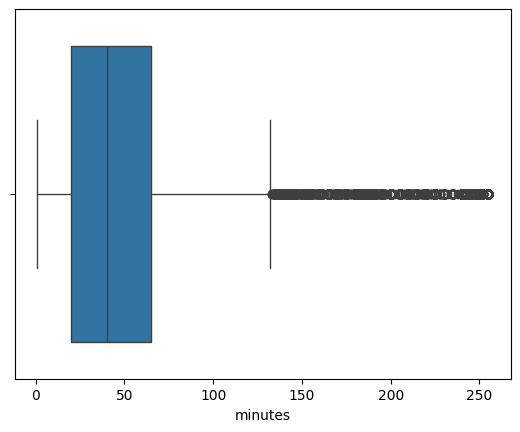

In [23]:
sns.boxplot(x=recipe_df_cleaned['minutes'])

Let's delete all rows which contains over per 95 n_steps.

In [24]:
q95_n_steps = recipe_df_cleaned['n_steps'].quantile(0.95)
filtered_df = recipe_df_cleaned[recipe_df_cleaned['n_steps'] > q95_n_steps]

recipe_df_cleaned = recipe_df_cleaned.drop(filtered_df.index)

recipe_df_cleaned.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,216820.000000,216820.000000,2.168200e+05,216820.000000,216820.000000
mean,224740.468564,56.282234,5.091130e+06,8.960137,8.880491
std,139376.741333,60.377591,9.531173e+07,4.461873,3.603747
min,38.000000,1.000000,2.700000e+01,0.000000,1.000000
25%,104641.500000,20.000000,5.810400e+04,6.000000,6.000000
50%,210605.000000,35.000000,1.784270e+05,8.000000,9.000000
75%,334797.500000,65.000000,4.073380e+05,12.000000,11.000000
max,537716.000000,255.000000,2.002290e+09,21.000000,43.000000


#### Analyzing cathegoric columns

Getting all columns that contain cathegorical data.

In [25]:
cathegorical_cols = recipe_df_cleaned.select_dtypes(include=['object', 'category']).columns
cathegorical_cols

Index(['name', 'submitted', 'tags', 'nutrition', 'steps', 'description',
       'ingredients'],
      dtype='object')

In [26]:
recipe_df_cleaned[cathegorical_cols].head()

,name,submitted,tags,nutrition,steps,description,ingredients
0,arriba baked winter squash mexican style,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]","['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ..."
1,a bit different breakfast pizza,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]","['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg..."
2,all in the kitchen chili,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]","['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato..."
3,alouette potatoes,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n..."
4,amish tomato ketchup for canning,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar..."


Splitting nutrition into several columns: [calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV) , and carbohydrates (PDV)].

In [27]:
recipe_df_cleaned['nutrition'] = recipe_df_cleaned['nutrition'].apply(ast.literal_eval)
recipe_df_cleaned['nutrition'] = recipe_df_cleaned['nutrition'].apply(lambda x: [float(i) for i in x])

In [28]:
nutrition_col_names = ['calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']

In [29]:
nutrition_df = recipe_df_cleaned['nutrition'].apply(pd.Series)
nutrition_df.columns = nutrition_col_names

recipe_df_cleaned = pd.concat([recipe_df_cleaned, nutrition_df], axis=1)

recipe_df_cleaned = recipe_df_cleaned.drop(columns=['nutrition'])

recipe_df_cleaned.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories (#),total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130.0,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45.0,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190.0,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [30]:
recipe_df_cleaned.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories (#),total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,216820.000000,216820.000000,2.168200e+05,216820.000000,216820.000000,216820.000000,216820.000000,216820.000000,216820.000000,216820.000000,216820.000000,216820.000000
mean,224740.468564,56.282234,5.091130e+06,8.960137,8.880491,460.646998,35.041564,81.577682,29.633489,33.973526,43.987100,15.067208
std,139376.741333,60.377591,9.531173e+07,4.461873,3.603747,1194.768895,76.532201,818.232971,131.785400,57.041027,94.136223,83.432255
min,38.000000,1.000000,2.700000e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,104641.500000,20.000000,5.810400e+04,6.000000,6.000000,171.700000,8.000000,9.000000,5.000000,6.000000,7.000000,4.000000
50%,210605.000000,35.000000,1.784270e+05,8.000000,9.000000,307.800000,20.000000,24.000000,14.000000,18.000000,22.000000,9.000000
75%,334797.500000,65.000000,4.073380e+05,12.000000,11.000000,509.200000,40.000000,66.000000,32.000000,50.000000,51.000000,16.000000
max,537716.000000,255.000000,2.002290e+09,21.000000,43.000000,434360.200000,17183.000000,362729.000000,29338.000000,6552.000000,10395.000000,36098.000000


In [31]:
percentiles_95 = recipe_df_cleaned[nutrition_col_names].quantile(0.95)

In [32]:
outliers_count = {}

for col in nutrition_col_names:
    outliers_count[col] = (recipe_df_cleaned[col] > percentiles_95[col]).sum()

outliers_count

{'calories (#)': 10840,
 'total fat (PDV)': 10798,
 'sugar (PDV)': 10822,
 'sodium (PDV)': 10829,
 'protein (PDV)': 10739,
 'saturated fat (PDV)': 10797,
 'carbohydrates (PDV)': 10663}

In [33]:
outliers_df = recipe_df_cleaned[(recipe_df_cleaned[nutrition_col_names] > percentiles_95).any(axis=1)]

recipe_df_cleaned = recipe_df_cleaned.drop(outliers_df.index)

recipe_df_cleaned.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories (#),total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130.0,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45.0,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
6,aww marinated olives,25274,15.0,21730,2002-04-14,"[15-minutes-or-less, time-to-make, course, mai...",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,380.7,53.0,7.0,24.0,6.0,24.0,6.0


In [34]:
recipe_df_cleaned.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories (#),total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,185429.000000,185429.000000,1.854290e+05,185429.000000,185429.000000,185429.000000,185429.000000,185429.000000,185429.000000,185429.000000,185429.000000,185429.000000
mean,227566.002826,53.622012,5.043093e+06,8.878935,8.839529,301.488174,22.142782,41.126161,17.916060,25.375847,27.615136,9.397904
std,138884.755785,57.728850,9.476455e+07,4.405043,3.549619,189.861976,19.550663,49.466527,18.002015,25.318335,28.276447,7.689497
min,38.000000,1.000000,2.700000e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,108456.000000,20.000000,5.914400e+04,6.000000,6.000000,154.700000,7.000000,8.000000,4.000000,6.000000,6.000000,3.000000
50%,215306.000000,35.000000,1.868020e+05,8.000000,9.000000,268.600000,17.000000,21.000000,12.000000,15.000000,18.000000,8.000000
75%,337192.000000,60.000000,4.189150e+05,12.000000,11.000000,415.100000,32.000000,54.000000,26.000000,41.000000,41.000000,14.000000
max,537716.000000,255.000000,2.002285e+09,21.000000,43.000000,1194.300000,108.000000,260.000000,88.000000,105.000000,142.000000,41.000000


Since there a bunch of outliers, the best I can do is to replace their value to percentile 95.

### Saving current state of the dataset

In [35]:
recipe_df_cleaned.to_csv("../data/processed/recipe_to_db.csv", index=False)